#installing dependencies

In [ ]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))
    !nvidia-smi

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4
Mon Dec 26 18:25:30 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   67C    P0    31W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                            

This notebook works fine with transformers 4.12, it is not tested on newer versions

In [ ]:
!pip install transformers==4.12.2
!pip install farasapy==0.0.14
!pip install pyarabic==0.6.14
!git clone https://github.com/aub-mind/arabert
!pip install emoji==1.6.1
!pip install sentencepiece==0.1.96

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 3.1 MB 31.9 MB/s 
     |████████████████████████████████| 182 kB 76.8 MB/s 
     |████████████████████████████████| 3.3 MB 69.7 MB/s 
     |████████████████████████████████| 880 kB 75.5 MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895260 sha256=2ef2bf4ec496de334e2c7c8e2898f428a44cb87f78e231e5bc578486b10dd40b
  Stored in directory: /root/.cache/pip/wheels/82/ab/9b/c15899bf659ba74f623ac776e861cf2eb8608c1825ddec66a4
Successfully built sacremoses
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 126 kB 32.1 MB/s 
Cloning into 'arabert'...
remote: Enumerating objects: 600, done.
remote: Counting objects: 100% (65/65), done.
remo

Let's download some Arabic text classification datasets

In [ ]:
!git clone https://github.com/elnagara/HARD-Arabic-Dataset
!git clone https://github.com/mahmoudnabil/ASTD
!git clone https://github.com/nora-twairesh/AraSenti
!git clone https://github.com/mohamedadaly/LABR
!wget http://homepages.inf.ed.ac.uk/wmagdy/Resources/ArSAS.zip
!unzip ArSAS.zip
!unrar x '/content/HARD-Arabic-Dataset/data/unbalanced-reviews.rar'
!unzip '/content/HARD-Arabic-Dataset/data/balanced-reviews.zip'

Cloning into 'HARD-Arabic-Dataset'...
remote: Enumerating objects: 100, done.
remote: Total 100 (delta 0), reused 0 (delta 0), pack-reused 100
Receiving objects: 100% (100/100), 116.36 MiB | 29.69 MiB/s, done.
Resolving deltas: 100% (35/35), done.
Cloning into 'ASTD'...
remote: Enumerating objects: 29, done.
remote: Total 29 (delta 0), reused 0 (delta 0), pack-reused 29
Unpacking objects: 100% (29/29), done.
Cloning into 'AraSenti'...
remote: Enumerating objects: 20, done.
remote: Total 20 (delta 0), reused 0 (delta 0), pack-reused 20
Unpacking objects: 100% (20/20), done.
Cloning into 'LABR'...
remote: Enumerating objects: 37, done.
remote: Total 37 (delta 0), reused 0 (delta 0), pack-reused 37
Unpacking objects: 100% (37/37), done.
--2022-12-26 18:26:16--  http://homepages.inf.ed.ac.uk/wmagdy/Resources/ArSAS.zip
Resolving homepages.inf.ed.ac.uk (homepages.inf.ed.ac.uk)... 129.215.32.113
Connecting to homepages.inf.ed.ac.uk (homepages.inf.ed.ac.uk)|129.215.32.113|:80... connected.
HTT

#Trainer

Start the training procedure

In [ ]:
import numpy as np
import pandas as pd
import torch
import random
import matplotlib.pyplot as plt
import copy

from arabert.preprocess import ArabertPreprocessor
from sklearn.metrics import (accuracy_score, classification_report,
                             confusion_matrix, f1_score, precision_score,
                             recall_score)
from torch.utils.data import DataLoader, Dataset
from transformers import (AutoConfig, AutoModelForSequenceClassification,
                          AutoTokenizer, BertTokenizer, Trainer,
                          TrainingArguments)
from transformers.data.processors.utils import InputFeatures

List all the datasets we have

In [ ]:
from sklearn import model_selection
##############For Training Data#####################
# Read the data from the csv file named 'preprocessedData.csv' arabic data
train1 = pd.read_csv('./cleaned_train.csv', encoding='utf-8')
train2 = pd.read_csv('./cleaned_dev.csv', encoding='utf-8')

train = pd.concat([train1, train2], ignore_index=True)


# Split the data into train and test
train, test = model_selection.train_test_split(train, test_size=0.01)
# Unpack the data into text and stance
Train_X = train['text']
stance_Train_Y = train['stance']
cat_Train_Y = train['category']

# Unpack the data into text, and stance
Test_X = test['text']
stance_Test_Y = test['stance']
cat_Test_Y = test['category']

In [ ]:
# select a model from the huggingface modelhub https://huggingface.co/models?language=ar
model_name = 'aubmindlab/bert-base-arabertv02-twitter' # we are going to use the twitter AraBERT since it has emojis and dialects

Create and apply preprocessing using the AraBERT processor

In [ ]:
arabic_prep = ArabertPreprocessor(model_name)
Train_X = Train_X.apply(lambda x: arabic_prep.preprocess(x))
Test_X = Test_X.apply(lambda x: arabic_prep.preprocess(x))  

Now we need to check the tokenized sentence length to decide on the maximum sentence length value

In [ ]:
tok = AutoTokenizer.from_pretrained(model_name)

loading file https://huggingface.co/aubmindlab/bert-base-arabertv02-twitter/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/dbef00ddc9b64a66ba8057785b166b744cef2a41be973446ad897a56ad317019.aa4ad61e3b0a52c7bcf5410af86ef01a27cf1147665acd6bfba80731d053f78a
loading file https://huggingface.co/aubmindlab/bert-base-arabertv02-twitter/resolve/main/tokenizer.json from cache at /root/.cache/huggingface/transformers/46fef3ab20b06df535befe0412ab892f9baec0a9f8e64d75a0142a67ce366959.c7c33ce0611a0a55c52a9ba4c03992b47db6e8b9862113443132ed9af7185a19
loading file https://huggingface.co/aubmindlab/bert-base-arabertv02-twitter/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/aubmindlab/bert-base-arabertv02-twitter/resolve/main/special_tokens_map.json from cache at /root/.cache/huggingface/transformers/7f74425f6809cddb05d5de7967a5af4e325b04245017a7b1917fe7d5cfb06988.dd8bd9bfd3664b530ea4e645105f557769387b3da9f79bdb55ed556bdd80611d
loading file

Training Sentence Lengths: 


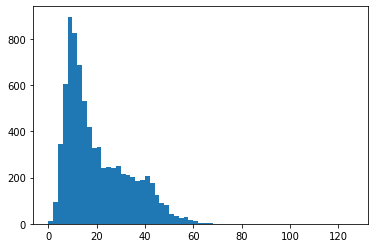

Testing Sentence Lengths: 


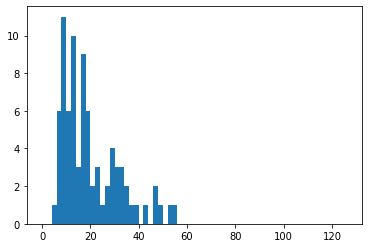

In [ ]:
print("Training Sentence Lengths: ")
plt.hist([ len(tok.tokenize(sentence)) for sentence in Train_X.to_list()],bins=range(0,128,2))
plt.show()

print("Testing Sentence Lengths: ")
plt.hist([ len(tok.tokenize(sentence)) for sentence in Test_X.to_list()],bins=range(0,128,2))
plt.show()

Let's select 100 as our maximum sentence length, and check how many sequences will be truncated

In [ ]:
max_len = 120
print("Truncated training sequences: ", sum([len(tok.tokenize(sentence)) > max_len for sentence in Test_X.to_list()]))

print("Truncated testing sequences: ", sum([len(tok.tokenize(sentence)) > max_len for sentence in Test_X.to_list()]))

Truncated training sequences:  0
Truncated testing sequences:  0


8 out of ~4000 for testing isn't bad

Now let's create a classification dataset to load the data

In [ ]:
class ClassificationDataset(Dataset):
    def __init__(self, text, target, model_name, max_len, label_map):
      super(ClassificationDataset).__init__()
      """
      Args:
      text (List[str]): List of the training text
      target (List[str]): List of the training labels
      tokenizer_name (str): The tokenizer name (same as model_name).
      max_len (int): Maximum sentence length
      label_map (Dict[str,int]): A dictionary that maps the class labels to integer
      """
      self.text = text
      self.target = target
      self.tokenizer_name = model_name
      self.tokenizer = AutoTokenizer.from_pretrained(model_name)
      self.max_len = max_len
      self.label_map = label_map
      

    def __len__(self):
      return len(self.text)

    def __getitem__(self,item):
      text = str(self.text[item])
      text = " ".join(text.split())
        
      inputs = self.tokenizer(
          text,
          max_length=self.max_len,
          padding='max_length',
          truncation=True
      )      
      return InputFeatures(**inputs,label=self.label_map[self.target[item]])

In [ ]:

label_map = { v:index for index, v in enumerate(['info_news', 'personal', 'celebrity', 'plan', 'unrelated', 'others', 'requests', 'rumors', 'advice', 'restrictions']) }
print(label_map)

train_dataset = ClassificationDataset(
    Train_X.to_list(),
    cat_Train_Y.to_list(),
    model_name,
    max_len,
    label_map
  )
test_dataset = ClassificationDataset(
    Test_X.to_list(),
    cat_Test_Y.to_list(),
    model_name,
    max_len,
    label_map
  )

loading file https://huggingface.co/aubmindlab/bert-base-arabertv02-twitter/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/dbef00ddc9b64a66ba8057785b166b744cef2a41be973446ad897a56ad317019.aa4ad61e3b0a52c7bcf5410af86ef01a27cf1147665acd6bfba80731d053f78a
loading file https://huggingface.co/aubmindlab/bert-base-arabertv02-twitter/resolve/main/tokenizer.json from cache at /root/.cache/huggingface/transformers/46fef3ab20b06df535befe0412ab892f9baec0a9f8e64d75a0142a67ce366959.c7c33ce0611a0a55c52a9ba4c03992b47db6e8b9862113443132ed9af7185a19
loading file https://huggingface.co/aubmindlab/bert-base-arabertv02-twitter/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/aubmindlab/bert-base-arabertv02-twitter/resolve/main/special_tokens_map.json from cache at /root/.cache/huggingface/transformers/7f74425f6809cddb05d5de7967a5af4e325b04245017a7b1917fe7d5cfb06988.dd8bd9bfd3664b530ea4e645105f557769387b3da9f79bdb55ed556bdd80611d
loading file

{'info_news': 0, 'personal': 1, 'celebrity': 2, 'plan': 3, 'unrelated': 4, 'others': 5, 'requests': 6, 'rumors': 7, 'advice': 8, 'restrictions': 9}


loading file https://huggingface.co/aubmindlab/bert-base-arabertv02-twitter/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/dbef00ddc9b64a66ba8057785b166b744cef2a41be973446ad897a56ad317019.aa4ad61e3b0a52c7bcf5410af86ef01a27cf1147665acd6bfba80731d053f78a
loading file https://huggingface.co/aubmindlab/bert-base-arabertv02-twitter/resolve/main/tokenizer.json from cache at /root/.cache/huggingface/transformers/46fef3ab20b06df535befe0412ab892f9baec0a9f8e64d75a0142a67ce366959.c7c33ce0611a0a55c52a9ba4c03992b47db6e8b9862113443132ed9af7185a19
loading file https://huggingface.co/aubmindlab/bert-base-arabertv02-twitter/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/aubmindlab/bert-base-arabertv02-twitter/resolve/main/special_tokens_map.json from cache at /root/.cache/huggingface/transformers/7f74425f6809cddb05d5de7967a5af4e325b04245017a7b1917fe7d5cfb06988.dd8bd9bfd3664b530ea4e645105f557769387b3da9f79bdb55ed556bdd80611d
loading file

Check the dataset output

In [ ]:
print(next(iter(train_dataset)))

InputFeatures(input_ids=[2, 16611, 1864, 1089, 4155, 463, 1451, 16136, 40204, 1163, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], attention_mask=[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], token_type_ids=[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Create a function that return a pretrained model ready to do classification

In [ ]:
def model_init():
    return AutoModelForSequenceClassification.from_pretrained(model_name, return_dict=True, num_labels=len(label_map))

Define whatever metric you want here

In [ ]:
def compute_metrics(p): #p should be of type EvalPrediction
  preds = np.argmax(p.predictions, axis=1)
  assert len(preds) == len(p.label_ids)
  #print(classification_report(p.label_ids,preds))
  #print(confusion_matrix(p.label_ids,preds))
  macro_f1 = f1_score(p.label_ids,preds,average='macro')
  #macro_precision = precision_score(p.label_ids,preds,average='macro')
  #macro_recall = recall_score(p.label_ids,preds,average='macro')
  acc = accuracy_score(p.label_ids,preds)
  return {       
      'macro_f1' : macro_f1,
      'accuracy': acc
  }

In [ ]:
def set_seed(seed=42):
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)
  torch.backends.cudnn.deterministic=True
  torch.backends.cudnn.benchmark = False

#Regular Training

Define our training parameters.
Check the TrainingArguments documentation for more options https://huggingface.co/transformers/main_classes/trainer.html#trainingarguments

In [ ]:
training_args = TrainingArguments( 
    output_dir= "./train",    
    adam_epsilon = 1e-8,
    learning_rate = 2e-5,
    fp16 = False, # enable this when using V100 or T4 GPU
    per_device_train_batch_size = 16, # up to 64 on 16GB with max len of 128
    per_device_eval_batch_size = 128,
    gradient_accumulation_steps = 2, # use this to scale batch size without needing more memory
    num_train_epochs= 2,
    warmup_ratio = 0,
    do_eval = True,
    evaluation_strategy = 'epoch',
    save_strategy = 'epoch',
    load_best_model_at_end = True, # this allows to automatically get the best model at the end based on whatever metric we want
    metric_for_best_model = 'macro_f1',
    greater_is_better = True,
    seed = 25
  )

set_seed(training_args.seed)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


Create the trainer

In [ ]:
trainer = Trainer(
    model = model_init(),
    args = training_args,
    train_dataset = train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)

loading configuration file https://huggingface.co/aubmindlab/bert-base-arabertv02-twitter/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/1109ac490c1eb90f74960e17c00032f27ea3c4be159567d7ed5d2b5908f9855c.01294502d101541d98086466d32c6b4f04698a90a573cd06480d05bd0c20b2aa
Model config BertConfig {
  "_name_or_path": "bert-base-arabertv02",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7",
    "8": "LABEL_8",
    "9": "LABEL_9"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4,
    "LABEL_5": 5,
    

In [ ]:
#start the training
trainer.train()

***** Running training *****
  Num examples = 7908
  Num Epochs = 2
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 2
  Total optimization steps = 494


Epoch,Training Loss,Validation Loss,Macro F1,Accuracy
0,No log,0.950999,0.319343,0.700000
1,No log,0.908927,0.314630,0.687500


***** Running Evaluation *****
  Num examples = 80
  Batch size = 128
Saving model checkpoint to ./train/checkpoint-247
Configuration saved in ./train/checkpoint-247/config.json
Model weights saved in ./train/checkpoint-247/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 80
  Batch size = 128
Saving model checkpoint to ./train/checkpoint-494
Configuration saved in ./train/checkpoint-494/config.json
Model weights saved in ./train/checkpoint-494/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from ./train/checkpoint-247 (score: 0.3193433179723502).


TrainOutput(global_step=494, training_loss=0.9960382747264044, metrics={'train_runtime': 334.2517, 'train_samples_per_second': 47.318, 'train_steps_per_second': 1.478, 'total_flos': 975143165028480.0, 'train_loss': 0.9960382747264044, 'epoch': 2.0})

Save the model, the tokenizer and the config

In [ ]:
inv_label_map = inv_label_map = { v:k for k, v in label_map.items()}
print(inv_label_map)
trainer.model.config.label2id = label_map
trainer.model.config.id2label = inv_label_map
trainer.save_model("output_dir")
train_dataset.tokenizer.save_pretrained("output_dir")

Saving model checkpoint to output_dir
Configuration saved in output_dir/config.json


{0: 'info_news', 1: 'personal', 2: 'celebrity', 3: 'plan', 4: 'unrelated', 5: 'others', 6: 'requests', 7: 'rumors', 8: 'advice', 9: 'restrictions'}


Model weights saved in output_dir/pytorch_model.bin
tokenizer config file saved in output_dir/tokenizer_config.json
Special tokens file saved in output_dir/special_tokens_map.json


('output_dir/tokenizer_config.json',
 'output_dir/special_tokens_map.json',
 'output_dir/vocab.txt',
 'output_dir/added_tokens.json',
 'output_dir/tokenizer.json')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#copy the model to drive
!cp -r output_dir /content/drive/MyDrive

## predict using the saved model

In [ ]:
from transformers import pipeline

In [ ]:
# initialize pipline
pipe = pipeline("sentiment-analysis", model="output_dir", device=0, return_all_scores=True)

loading configuration file output_dir/config.json
Model config BertConfig {
  "_name_or_path": "aubmindlab/bert-base-arabertv02-twitter",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "info_news",
    "1": "personal",
    "2": "celebrity",
    "3": "plan",
    "4": "unrelated",
    "5": "others",
    "6": "requests",
    "7": "rumors",
    "8": "advice",
    "9": "restrictions"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "advice": 8,
    "celebrity": 2,
    "info_news": 0,
    "others": 5,
    "personal": 1,
    "plan": 3,
    "requests": 6,
    "restrictions": 9,
    "rumors": 7,
    "unrelated": 4
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_

In [ ]:
import csv

dataframe = pd.DataFrame

Test_Data = pd.read_csv('cleaned_test_farasa.csv', encoding='utf-8')
fields = ['id','category']

data_frame = pd.DataFrame(columns=fields)

for i in range(len(Test_Data)):

  id = Test_Data['id'][i]
  text = Test_Data['text'][i]

  prediction_list_dict = pipe(text)[0]
  # [{'label': 'info_news', 'score': 0.32171744108200073}]

  final_label = ""
  final_score = -1

  for label_score in prediction_list_dict:
    label = label_score['label']
    score = label_score['score']
    if score > final_score:
      final_score = score 
      final_label = label
  data_frame = data_frame.append({'id': id, 'category': final_label}, ignore_index=True)




/usr/local/lib/python3.8/dist-packages/transformers/pipelines/base.py:908: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


In [ ]:
data_frame

,id,category
0,0,celebrity
1,1,unrelated
2,2,personal
3,3,info_news
4,4,info_news
...,...,...
1995,1995,info_news
1996,1996,personal
1997,1997,info_news
1998,1998,info_news


In [ ]:
data_frame.to_csv("results_category.csv",index=False)

arabert/              cleaned_test_farasa.csv  results_category.csv
AraSenti/             cleaned_train.csv        sample_data/
ArSAS..txt            dev.csv                  test.csv
ArSAS.zip             drive/                   train/
ASTD/                 HARD-Arabic-Dataset/     train.csv
balanced-reviews.txt  LABR/                    unbalanced-reviews.txt
cleaned_dev.csv       output_dir/
